X_train: (1176, 55), X_test: (294, 55)

Training LogisticRegression...
LogisticRegression ROC-AUC: 0.7891, F1: 0.4478
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       247
           1       0.34      0.64      0.45        47

    accuracy                           0.75       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.83      0.75      0.77       294

LogisticRegression saved to C:\Users\kakinwande1\Employee_atrttion\models

Training RandomForest...
RandomForest ROC-AUC: 0.7818, F1: 0.1786
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.56      0.11      0.18        47

    accuracy                           0.84       294
   macro avg       0.70      0.55      0.55       294
weighted avg       0.81      0.84      0.80       294

RandomForest saved to C:\Users\kakinwande

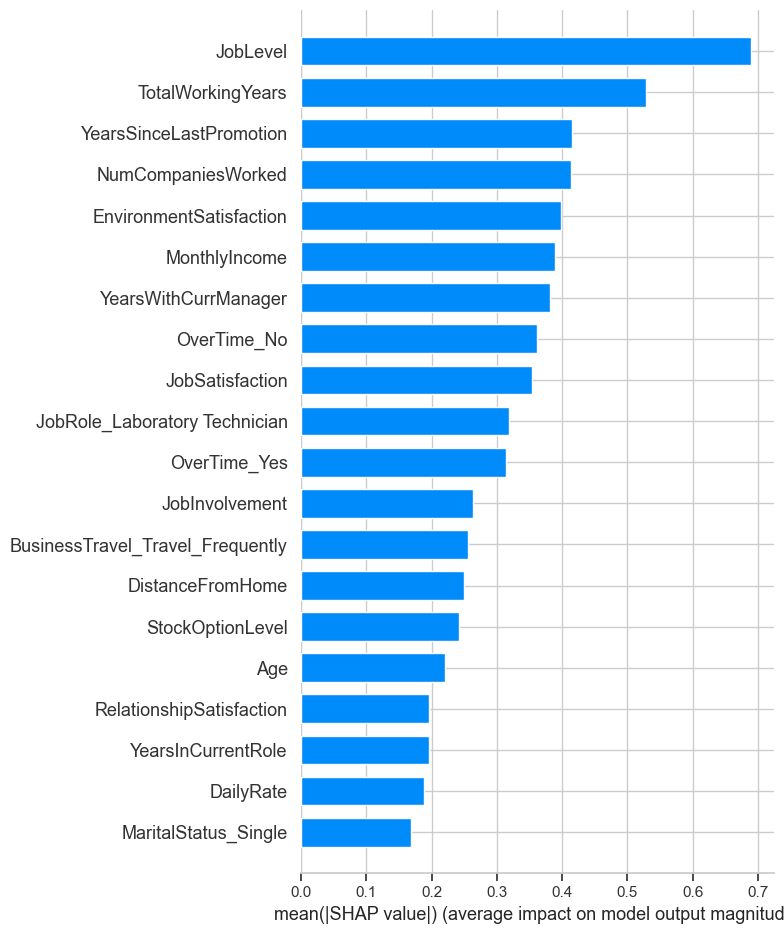

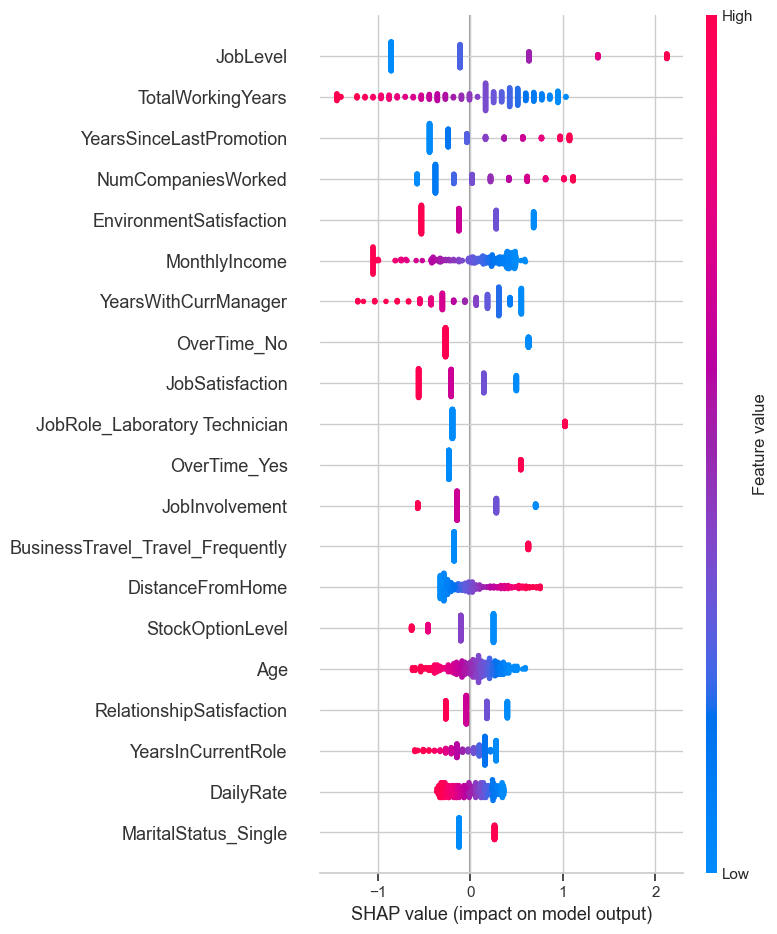

Top features driving attrition risk (for HR action):
- JobLevel: median=-0.06, impact on attrition risk
- TotalWorkingYears: median=-0.15, impact on attrition risk
- YearsSinceLastPromotion: median=-0.37, impact on attrition risk
- NumCompaniesWorked: median=-0.28, impact on attrition risk
- EnvironmentSatisfaction: median=0.25, impact on attrition risk


In [33]:
# ============================================================
# Employee Attrition Project - Notebook 05
# 05_final_model_thresholding_and_insights.ipynb
# Purpose:
#   - Final model selection
#   - Threshold tuning for Attrition=Yes
#   - SHAP explainability for HR insights
# ============================================================

# -------------------------
# 1. Imports
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

sns.set(style='whitegrid')

# -------------------------
# 2. Paths
# -------------------------
project_root = r"C:\Users\kakinwande1\Employee_atrttion"
processed_folder = os.path.join(project_root, "data", "processed")
models_folder = os.path.join(project_root, "models")
os.makedirs(models_folder, exist_ok=True)

# Load processed train/test data
X_train = pd.read_csv(os.path.join(processed_folder, "train.csv"))
X_test = pd.read_csv(os.path.join(processed_folder, "test.csv"))
y_train = pd.read_csv(os.path.join(processed_folder, "y_train.csv")).squeeze()
y_test = pd.read_csv(os.path.join(processed_folder, "y_test.csv")).squeeze()

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# -------------------------
# 3. Align Test Columns
# -------------------------
# Ensure X_test has same columns as X_train
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0  # missing one-hot columns filled with 0
X_test = X_test[X_train.columns]  # reorder columns

# -------------------------
# 4. Define Models
# -------------------------
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200,
                             scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
                             use_label_encoder=False,
                             eval_metric='logloss',
                             random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
}

results = {}

# -------------------------
# 5. Train, Evaluate, Save Models
# -------------------------
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Compute probabilities (for thresholding)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)

    # Default threshold 0.5
    y_pred = (y_proba >= 0.5).astype(int)

    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save model
    joblib.dump(model, os.path.join(models_folder, f"{name}_model.pkl"))
    print(f"{name} saved to {models_folder}")

    results[name] = {"model": model, "y_proba": y_proba, "roc_auc": roc_auc, "f1": f1}

# -------------------------
# 6. Select Final Model
# -------------------------
# Choose based on minority class F1 (Attrition=Yes)
best_model_name = max(results, key=lambda k: results[k]['f1'])
final_model = results[best_model_name]['model']
print(f"\nFinal model selected: {best_model_name}")

# -------------------------
# 7. Threshold Tuning for Attrition=Yes
# -------------------------
y_proba_final = results[best_model_name]['y_proba']
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_final)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal probability threshold for Attrition=Yes: {best_threshold:.3f}")
print(f"F1 at optimal threshold: {f1_scores[best_idx]:.4f}")

# Apply threshold
y_pred_final = (y_proba_final >= best_threshold).astype(int)
print("Classification Report at optimal threshold:")
print(classification_report(y_test, y_pred_final))

# -------------------------
# 8. SHAP Explainability
# -------------------------
shap.initjs()

if best_model_name in ["RandomForest", "XGBoost"]:
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test)
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
elif best_model_name == "LogisticRegression":
    # Use 'interventional' for linear models like LogisticRegression
    explainer = shap.LinearExplainer(final_model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)
    sv = shap_values

elif best_model_name == "SVM":
    # SVM explainability is harder; use KernelExplainer
    explainer = shap.KernelExplainer(final_model.predict_proba, X_train.sample(100, random_state=42))
    shap_values = explainer.shap_values(X_test.sample(50, random_state=42))
    sv = shap_values

# Global SHAP summary
shap.summary_plot(sv, X_test, plot_type="bar")
shap.summary_plot(sv, X_test)

# -------------------------
# 9. HR-Level Business Insights
# -------------------------
# Show top 5 features contributing to attrition
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "median_value": X_train.median(),
    "shap_mean_abs": np.abs(sv).mean(axis=0)
}).sort_values(by="shap_mean_abs", ascending=False)

top_features = importance_df.head(5)
print("Top features driving attrition risk (for HR action):")
for _, row in top_features.iterrows():
    print(f"- {row.feature}: median={row.median_value:.2f}, impact on attrition risk")
